In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from matplotlib.patches import Rectangle

### Functions

In [91]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        data_sec = datafile[var]
        dict_var[var] = data_sec[idx]
        
    
    return dict_var       

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [56]:
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticks([])

In [6]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

### Import data

In [9]:
##Forwards - Eastern JdF
#Jan
datafas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
datafrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

#July
datafas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
databvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backADM_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

#July
databvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backadm_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

##Forwards - SJGI
# Jan
datafg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18_PR/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
datafg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
# Jan
databg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
databg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jul18/back_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
databsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

data_dict = {'datafvs':data,'datafas':datafas,'datafds':datafds,'datafrsvs':datafrsvs,'datafsjvs':datafsjvs,'datafhsvs':datafhsvs,
             'datafvs07':datafvs07,'datafas07':datafas07,'datafds07':datafds07,'datafrsvs07':datafrsvs07,'datafsjvs07':datafsjvs07,'datafhsvs07':datafhsvs07,
             'databvs':databvs,'databas':databas,'databds':databds,'databrsvs':databrsvs,'databsjvs':databsjvs,'databhsvs':databhsvs,
             'databvs07':databvs07,'databas07':databas07,'databds07':databds07,'databrsvs07':databrsvs07,'databsjvs07':databsjvs07,'databhsvs07':databhsvs07,
             'datafpr':datafpr,'datafg1':datafg1,'datafg2':datafg2,'datafrspr':datafrspr,'datafsjpr':datafsjpr,'datafhspr':datafhspr,
             'datafpr07':datafpr07,'datafg107':datafg107,'datafg207':datafg207,'datafrspr07':datafrspr07,'datafsjpr07':datafsjpr07,'datafhspr07':datafhspr07,
             'databpr':databpr,'databg1':databg1,'databg2':databg2,'databrspr':databrspr,'databsjpr':databsjpr,'databhspr':databhspr,
             'databpr07':databpr07,'databg107':databg107,'databg207':databg207,'databrspr07':databrspr07,'databsjpr07':databsjpr07,'databhspr07':databhspr07,
}

### Section plots

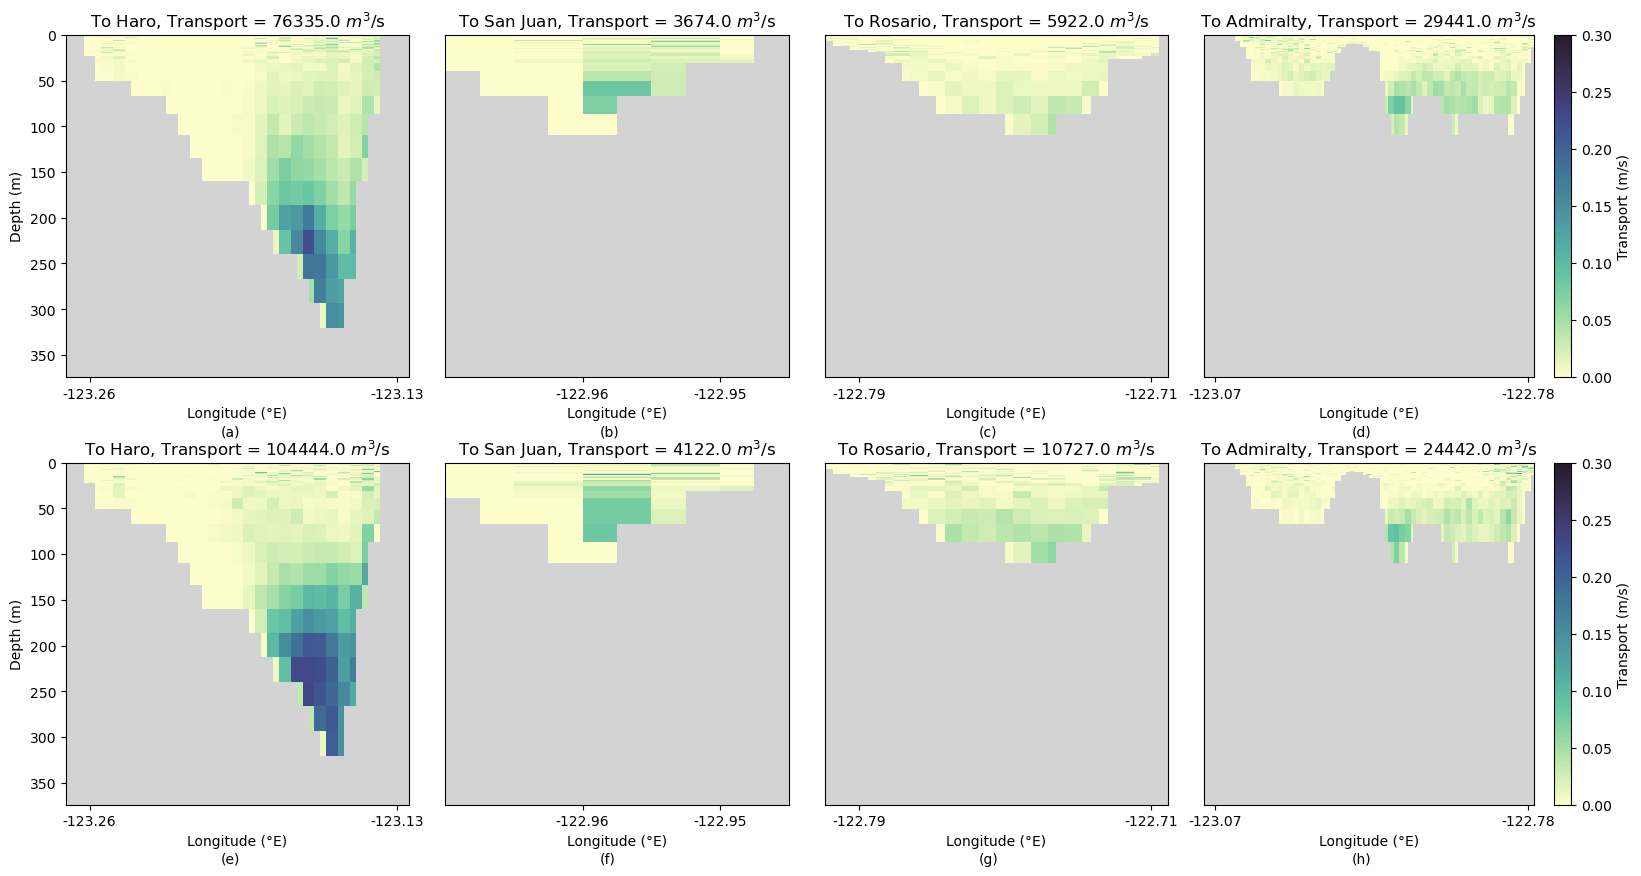

In [93]:
#VicSill to Haro
harofvs = get_secdata(data_dict['datafvs'],6)
rosfvs = get_secdata(data_dict['datafvs'],4)
admfvs = get_secdata(data_dict['datafvs'],2)
sjcfvs = get_secdata(data_dict['datafvs'],5)

#In summer
harofvs_jul = get_secdata(data_dict['datafvs07'],6)
rosfvs_jul = get_secdata(data_dict['datafvs07'],4)
admfvs_jul = get_secdata(data_dict['datafvs07'],2)
sjcfvs_jul = get_secdata(data_dict['datafvs07'],5)

lonWharo = 215
lonEharo = 245
latharo = 300
lonWros=284
lonEros=305
latros = 267
latsjc = 282
lonWsjc = 262
lonEsjc = 268
lonWadm = 200
lonEadm = 260
latadm = 218

section_transp = []
section_transp_jul = []
sectionnum = [0,2,3,4,5,6]
starttime = 1
endtime = 168

for section in sectionnum:
    section_transp.append(get_datat(data_dict['datafvs'],section,starttime,endtime))
    section_transp_jul.append(get_datat(data_dict['datafvs07'],section,starttime,endtime))


title = f'To Haro, Transport = {np.round(section_transp[5],0)} $m^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transp[4],0)} $m^3$/s'
title3 = f'To Rosario, Transport = {np.round(section_transp[3],0)} $m^3$/s'
title4 = f'To Admiralty, Transport = {np.round(section_transp[1],0)} $m^3$/s'
time = 168

smin = 28
smax = 33

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,harofvs['final_lon'],harofvs['final_z'],harofvs['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax3,rosfvs['final_lon'],rosfvs['final_z'],rosfvs['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax4,admfvs['final_lon'],admfvs['final_z'],admfvs['final_transp'],lonWadm,lonEadm,latadm,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f'To Haro, Transport = {np.round(section_transp_jul[5],0)} $m^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transp_jul[4],0)} $m^3$/s'
title3 = f'To Rosario, Transport = {np.round(section_transp_jul[3],0)} $m^3$/s'
title4 = f'To Admiralty, Transport = {np.round(section_transp_jul[1],0)} $m^3$/s'

plotCS(ax5,harofvs_jul['final_lon'],harofvs_jul['final_z'],harofvs_jul['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax6,sjcfvs_jul['final_lon'],sjcfvs_jul['final_z'],sjcfvs_jul['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax7,rosfvs_jul['final_lon'],rosfvs_jul['final_z'],rosfvs_jul['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax8,admfvs_jul['final_lon'],admfvs_jul['final_z'],admfvs_jul['final_transp'],lonWadm,lonEadm,latadm,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1, hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/forwardVS_section.png',bbox_inches='tight')
